In [1]:
import json
import numpy as np
from pandas.io.json import json_normalize

import os
import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split
import keras 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Flatten , CuDNNLSTM , GRU
from keras.layers import Dropout
import keras

from keras import callbacks
from keras.callbacks import  CSVLogger


# Model Evaluations
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


In [2]:
def load_file(filepath,i):
    with open(filepath) as f:
        data = json.load(f)
    imu = data['imu']['data']
    emg = data['emg']['data']
    emg = np.array(emg)
    imu = np.array(imu)
    imu_gyr = np.array([(e['gyroscope']) for e in imu])
    imu_acc = np.array([(e['acceleration']) for e in imu])
    imu_orn = np.array([(e['orientation']) for e in imu])
    #timestamp = [i]
    #timestamp = np.repeat(timestamp, 400, axis=None)
    #timestamp= timestamp.reshape(400,1)
    dataset = tf.concat([emg, imu_gyr, imu_acc, imu_orn], axis=1, name='concat')
    dataset = np.array(dataset)
    return dataset

In [3]:
data_path = '../input/emgimu/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet-master/Dataset/'

In [4]:
# For Files Data
X = []
y = []
i=0
for folder in  os.listdir(data_path) : 
    j=0
    files = gb.glob(pathname= str( data_path  + folder + '/*.json'))
    for file in files: 
        data = load_file(file,j)
        X.append(data)
        y.append(i)
        j+=1
    i+=1

print(f'we have {len(X)} items in X ')

2022-10-29 22:19:51.561781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 22:19:51.693104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 22:19:51.693976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 22:19:51.697195: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

we have 780 items in X 


In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=20)


In [7]:
print('X shape is : ' , X.shape)
print('y shape is : ' , y.shape)

X shape is :  (780, 400, 18)
y shape is :  (780,)


In [8]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

In [9]:
def getcode(n) : 
    for x , y in mapping.items() : 
        if n == y : 
            return x

# Building Model with files

In [10]:
X_train_f, X_split_f, y_train_f, y_split_f = train_test_split(X, y, test_size=0.30, random_state=42)
X_test_f, X_valid_f, y_test_f, y_valid_f = train_test_split(X_split_f, y_split_f, test_size=0.50, random_state=42)

In [11]:
# X_train_f = X_train_f.reshape(X_train_f.shape[0] , X_train_f.shape[1]*X_train_f.shape[2])
# X_valid_f = X_valid_f.reshape(X_valid_f.shape[0] , X_valid_f.shape[1]*X_valid_f.shape[2])
# X_test_f = X_test_f.reshape(X_test_f.shape[0] , X_test_f.shape[1]*X_test_f.shape[2])

X_train_f = X_train_f.reshape(len(X_train_f), X_train_f.shape[1],18)
X_valid_f = X_valid_f.reshape(len(X_test_f), X_test_f.shape[1],18)
X_test_f = X_test_f.reshape(len(X_valid_f), X_valid_f.shape[1],18)

In [12]:
print(X_train_f.shape)
print(X_test_f.shape)

(546, 400, 18)
(117, 400, 18)


In [13]:
y_train_f = to_categorical(y_train_f)
y_test_f=to_categorical(y_test_f)
y_valid_f=to_categorical(y_valid_f)

In [14]:
model = keras.models.Sequential([
        keras.layers.CuDNNLSTM(units=128, return_sequences=True, input_shape =(400,18)),
#         keras.layers.Dropout(rate=0.3) , 
        keras.layers.CuDNNLSTM(units=64, return_sequences=True),
        keras.layers.Dropout(rate=0.3) , 
        keras.layers.Flatten(),
#         keras.layers.Dense(256,activation='relu' ) ,    
#         keras.layers.Dense(128,activation='relu') ,    
#         keras.layers.Dense(64,activation='relu') ,        
#         keras.layers.Dropout(rate=0.3) ,            
        keras.layers.Dense(26,activation='softmax') ,    
        ])
# 


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 400, 128)          75776     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 400, 64)           49664     
_________________________________________________________________
dropout (Dropout)            (None, 400, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 26)                665626    
Total params: 791,066
Trainable params: 791,066
Non-trainable params: 0
_________________________________________________________________


In [16]:
import tensorflow as tf

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('training_set_iranalysis3.csv',separator=',', append=False)
history = model.fit(X_train_f, y_train_f, batch_size=128, epochs=100, validation_data=(X_valid_f, y_valid_f),callbacks=[es,checkpointer,csv_logger])
model.save("./lstm.hdf5")

2022-10-29 22:20:04.218982: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-29 22:20:06.762340: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - 6s 348ms/step - loss: 2.4351 - accuracy: 0.3205 - precision: 0.8298 - recall: 0.0714 - val_loss: 1.0570 - val_accuracy: 0.7350 - val_precision: 0.9180 - val_recall: 0.4786
Epoch 2/100
5/5 [==============================] - 0s 70ms/step - loss: 0.6336 - accuracy: 0.8223 - precision: 0.9516 - recall: 0.7198 - val_loss: 0.5921 - val_accuracy: 0.7949 - val_precision: 0.8804 - val_recall: 0.6923
Epoch 3/100
5/5 [==============================] - 0s 66ms/step - loss: 0.1978 - accuracy: 0.9524 - precision: 0.9713 - recall: 0.9304 - val_loss: 0.3589 - val_accuracy: 0.8889 - val_precision: 0.9266 - val_recall: 0.8632
Epoch 4/100
5/5 [==============================] - 0s 72ms/step - loss: 0.0696 - accuracy: 0.9817 - precision: 0.9889 - recall: 0.9799 - val_loss: 0.3499 - val_accuracy: 0.8889 - val_precision: 0.9091 - val_recall: 0.8547
Epoch 5/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0228 - accuracy: 0.9982 - precision: 0.9982 - rec

In [17]:
test_results = model.evaluate(X_test_f, y_test_f, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

4/4 [==============================] - 0s 75ms/step - loss: 0.2802 - accuracy: 0.9316 - precision: 0.9561 - recall: 0.9316
Test results - Loss: 0.28024905920028687 - Accuracy: 93.16239356994629%


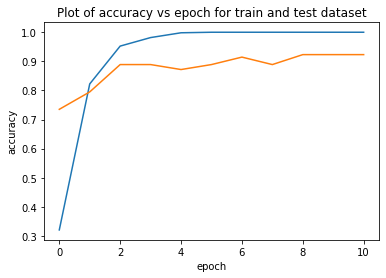

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

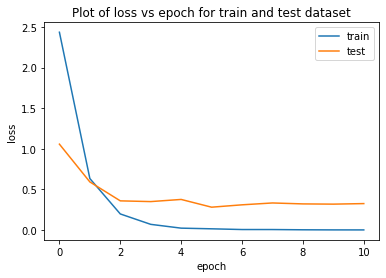

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [20]:
test_results = model.evaluate(X_test_f, y_test_f, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')
print(f'Test results - Precision: {test_results[2]*100} - Recall: {test_results[3]*100}%')

4/4 [==============================] - 0s 18ms/step - loss: 0.2802 - accuracy: 0.9316 - precision: 0.9561 - recall: 0.9316
Test results - Loss: 0.28024905920028687 - Accuracy: 93.16239356994629%
Test results - Precision: 95.61403393745422 - Recall: 93.16239356994629%


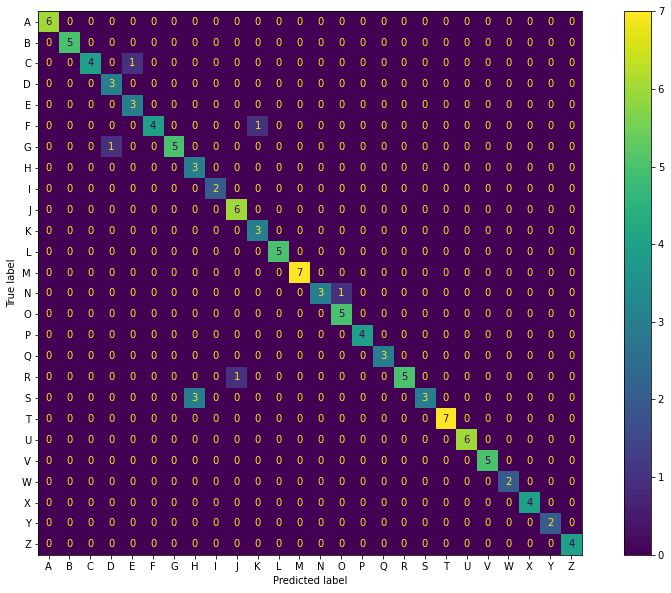

In [21]:
#Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix

y_predictions = model.predict(X_test_f)
cm=confusion_matrix(y_test_f.argmax(axis=1),y_predictions.argmax(axis=1))

clss = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clss)

plt.rcParams["figure.figsize"] = 15, 10
disp.plot()
plt.show()

In [22]:
#Classification Report

from sklearn.metrics import classification_report

report = classification_report(y_test_f.argmax(axis=1),y_predictions.argmax(axis=1), target_names=clss)
print(report)

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         6
           B       1.00      1.00      1.00         5
           C       1.00      0.80      0.89         5
           D       0.75      1.00      0.86         3
           E       0.75      1.00      0.86         3
           F       1.00      0.80      0.89         5
           G       1.00      0.83      0.91         6
           H       0.50      1.00      0.67         3
           I       1.00      1.00      1.00         2
           J       0.86      1.00      0.92         6
           K       0.75      1.00      0.86         3
           L       1.00      1.00      1.00         5
           M       1.00      1.00      1.00         7
           N       1.00      0.75      0.86         4
           O       0.83      1.00      0.91         5
           P       1.00      1.00      1.00         4
           Q       1.00      1.00      1.00         3
           R       1.00    

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

n_classes = len(clss)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clss)):
    fpr[i], tpr[i], _ = roc_curve(y_test_f[:, i], y_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_f.ravel(), y_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

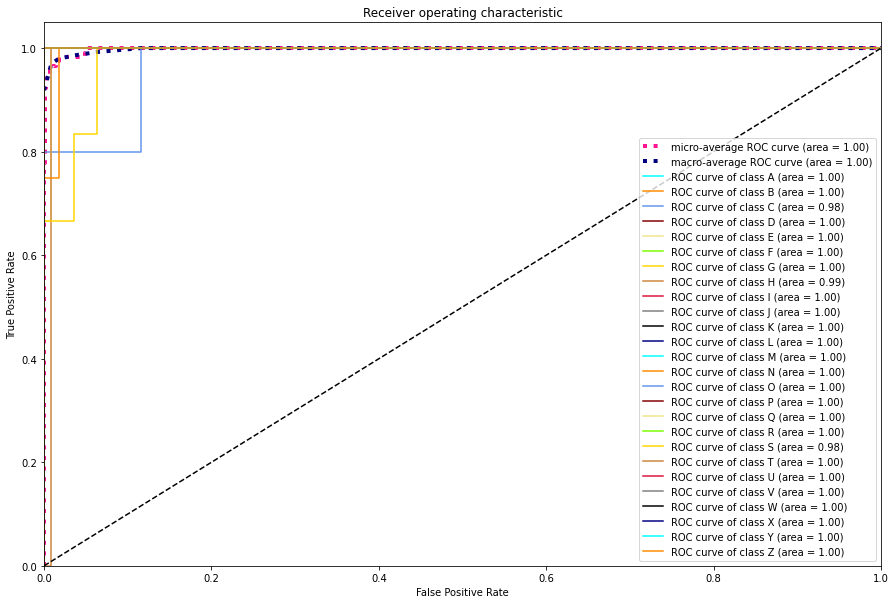

In [24]:
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "maroon","khaki", "lawngreen", "gold", "peru","crimson", "gray", "black", "navy"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label=f"ROC curve of class {clss[i]} (area = {roc_auc[i]:0.2f})",
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()